**Aims**:
 - extract the omics mentioned in multi-omics articles

**NOTE**: the articles not in PMC/with no full text need to be analysed separately, or at least highlighted.

In [1]:
%run notebook_setup.ipynb

In [2]:
import pandas
pandas.set_option('display.max_colwidth', 100)

In [3]:
%vault from pubmed_derived_data import literature, literature_subjects

Imported:

 - `literature` (67ED7D31)
 - `literature_subjects` (E63E424E)

at Friday, 24. Jul 2020 15:43

In [4]:
literature['title_abstract_text_subjects'] = (
    literature['title']
    + ' ' + literature['abstract_clean'].fillna('')
    + ' ' + literature_subjects.apply(lambda x: ' '.join(x[x == True].index), axis=1)
    + ' ' + literature['full_text'].fillna('')
)

In [5]:
omics_features = literature.index.to_frame().drop(columns='uid').copy()

In [6]:
from functools import partial
from helpers.text_processing import check_usage
from pandas import Series

check_usage_in_input = partial(
    check_usage,
    data=literature,
    column='title_abstract_text_subjects',
    limit=5  # show only first 5 results
)

In [7]:
TERM_IN_AT_LEAST_N_ARTICLES = 5

# Omics

## 1. Lookup by words which end with -ome

In [8]:
organelles = {
    'peroxisome',
    'proteasome',
    'ribosome',
    'exosome',
    'nucleosome',
    'polysome',
    'autosome',
    'autophagosome',
    'endosome',
    # chromosmes
    'autosome',
    'chromosome',
    'x-chromosome',
    'y-chromosome',
}

species = {
    'trichome'
}

tools_and_methods = {
    # dry lab
    'dphenome',
    'dgenome',
    'reactome',
    'rexposome',
    'phytozome',
    # wet lab
    'microtome'
}

In [9]:
note_an_ome = {
    'outcome',
    'middle-income',
    'welcome',
    'wellcome',  # :)
    'chrome',
    'some',
    'become',
    'home',
    'come',
    'overcome',
    'cytochrome',
    'syndrome',
    'ubiome',
    'fluorochrome',
    'post-genome',
    'ubiquitin-proteasome',  # UPS
    *tools_and_methods,
    *organelles,
    *species
}

In [10]:
from omics import get_ome_regexp
ome_re = get_ome_regexp()
get_ome_regexp??

Signature: get_ome_regexp() -> str
Docstring: <no docstring>
Source:   
def get_ome_regexp() -> str:
    return (
        # use look-ahead to allow for overlaps
        '(?='
            rf'(?:^|\s|{separators_re}|ome-)'
            '('
                r'(?:\w+)ome'
                '|'
                r'(?:(?:\w+-\w*)|\w+)ome'
            ')'
            # also, match plural form
            '(?:s)?'
            rf'(?:\s|$|{separators_re}|-)'
        ')'
    )
File:      ~/multi-omics/omics.py
Type:      function


In [11]:
ome_occurrences = (
    literature['title_abstract_text_subjects'].str.lower()
    .str.extractall(ome_re)[0]
    .to_frame('term').reset_index()
)
ome_occurrences = ome_occurrences[~ome_occurrences.term.isin(note_an_ome)]
ome_occurrences.head(3)

,uid,match,term
2,15687839,1,genome
7,16611894,0,genome
9,16611894,2,genome


### 1.1 Harmonise hyphenation

In [12]:
from helpers.text_processing import report_hyphenation_trends, harmonise_hyphenation

In [13]:
hyphenation_rules = report_hyphenation_trends(ome_occurrences.term)
hyphenation_rules

,more_popular,less_popular
0,metagenome,meta-genome
1,phosphoproteome,phospho-proteome
2,metaproteome,meta-proteome
3,whole-exome,wholeexome
4,pan-genome,pangenome
5,subgenome,sub-genome
6,sub-proteome,subproteome
7,endo-metabolome,endometabolome
8,exometabolome,exo-metabolome
9,cancer-genome,cancergenome


In [14]:
ome_occurrences.term = harmonise_hyphenation(ome_occurrences.term, hyphenation_rules)

### 1.2 Fix typos

In [15]:
from helpers.text_processing import find_term_typos, create_typos_map

In [16]:
ome_counts = ome_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
potential_ome_typos = find_term_typos(ome_counts, TERM_IN_AT_LEAST_N_ARTICLES - 1)
potential_ome_typos

,rare_term,popular_term,similarity
0,transcritome,transcriptome,0.960000
1,transciptome,transcriptome,0.960000
2,microbome,microbiome,0.947368
3,protenome,proteome,0.941176
4,mirome,mirnome,0.923077
5,1-metabolome,metabolome,0.909091


In [17]:
check_usage_in_input('1-metabolome')

uid
31216675     source), it may be possible to evaluate how Omic 1-metabolome relationships and associated path...
Name: title_abstract_text_subjects, dtype: object

In [18]:
check_usage_in_input('miRNAome')

uid
22661985    es are applying high-throughput miRNA sequencing (miRNAome) based identification and quantificat...
25783038    stemic responses of gut hormones, the circulating miRNAome and the metabolome in a rat model of ...
27716141     of PDGF-BB-regulated transcriptome, proteome and miRNAome (3-omics) in PASMCs. The results demo...
29312565    hts. Here, we performed an integrated analysis of miRNAome, proteome and metabolome, aimed to in...
29703144    of miRNA changes in aneuploid cells (Fig. \nFig. 1\nmiRNAome in aneuploid model cell lines. \na\...
Name: title_abstract_text_subjects, dtype: object

In [19]:
check_usage_in_input('miRome')

uid
26697401    ome (copy number), transcriptome, translatome and miRome levels (GEO series GSE56654, GSE56552 a...
Name: title_abstract_text_subjects, dtype: object

In [20]:
check_usage_in_input('rexposome')

uid
32318338    publicly available implementations. The packages \nrexposome\nomicRexposome\nexposome\nOmicsLonD...
Name: title_abstract_text_subjects, dtype: object

In [21]:
is_typo_subset_or_variant = {
    ('transcritome', 'transcriptome'): True,
    ('transciptome', 'transcriptome'): True,
    ('microbome', 'microbiome'): True,
    ('protenome', 'proteome'): True,
    ('mirome', 'mirnome'): True,
    ('1-metabolome', 'metabolome'): True
}
ome_typos_map = create_typos_map(potential_ome_typos, is_typo_subset_or_variant)

In [22]:
replaced = ome_occurrences.term[ome_occurrences.term.isin(ome_typos_map)]
replaced.value_counts()

mirome          6
1-metabolome    1
transciptome    1
transcritome    1
protenome       1
microbome       1
Name: term, dtype: int64

In [23]:
len(replaced)

11

In [24]:
ome_occurrences.term = ome_occurrences.term.replace(ome_typos_map)

### 1.3 Replace synonymous and narrow terms

In [25]:
ome_replacements = {}

#### miRNAomics → miRNomics

miRNAome is more popular name for -ome, while miRNomics is more popular for -omics.

In [26]:
ome_occurrences.term.value_counts().loc[['mirnome', 'mirnaome']]

mirnome     15
mirnaome    16
Name: term, dtype: int64

As I use -omcis for later on, for consistency I will change miRNAome → miRNome

In [27]:
ome_replacements['miRNAome'] = 'miRNome'

#### Cancer genome → genome

In [28]:
ome_occurrences.term.value_counts().loc[['genome', 'cancer-genome']]

genome           4855
cancer-genome       5
Name: term, dtype: int64

In [29]:
ome_replacements['cancer-genome'] = 'genome'

#### Host microbiome → microbiome

In [30]:
ome_occurrences.term.value_counts().loc[['microbiome', 'host-microbiome']]

microbiome         1763
host-microbiome      18
Name: term, dtype: int64

In [31]:
ome_replacements['host-microbiome'] = 'microbiome'

#### Replace the values

In [32]:
ome_occurrences.term = ome_occurrences.term.replace(
    {k.lower(): v.lower() for k, v in ome_replacements.items()}
)

### 1.4 Summarise popular \*ome terms

In [33]:
ome_counts = ome_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
ome_common_counts = ome_counts[ome_counts >= TERM_IN_AT_LEAST_N_ARTICLES]
ome_common_counts

index
genome                 1373
transcriptome           665
proteome                482
metabolome              354
microbiome              277
epigenome               134
whole-genome            131
exome                   118
metagenome               69
methylome                60
interactome              59
whole-exome              47
phenome                  44
lipidome                 35
phosphoproteome          34
secretome                27
metatranscriptome        25
metaproteome             19
whole-transcriptome      18
exposome                 13
translatome              13
virome                   12
mirnome                  11
fluxome                  10
regulome                  9
glycome                   8
degradome                 7
peptidome                 7
pan-genome                6
mycobiome                 5
Name: term, dtype: int64

In [34]:
ome_common_terms = Series(ome_common_counts.index)
ome_common_terms[ome_common_terms.str.endswith('some')]

19    exposome
Name: index, dtype: object

### 2. Lookup by omics and adjectives

In [35]:
from omics import get_omics_regexp

omics_re = get_omics_regexp()
get_omics_regexp??

Signature: get_omics_regexp() -> str
Docstring: <no docstring>
Source:   
def get_omics_regexp() -> str:
    return (
        # use look-ahead to allow for overlaps
        '(?='
            rf'(?:^|\s|{separators_re}|omic-)'
            # match '*-omic', '*-*omic', '*omic'
            '('
                # handle both *omic-*omic and *-*omic
                r'(?:\w+)omic'
                '|'
                r'(?:(?:\w+-\w*)|\w+)omic'
            ')'
            # match both *omic and omics, but capture only "omic" part
            '(?:s)?'
            rf'(?:\s|$|{separators_re}|-)'
        ')'
    )
File:      ~/multi-omics/omics.py
Type:      function


In [36]:
check_usage_in_input('integromics')

uid
23105932    endium and integrative omics analyses, so-called "integromics", have extended our understanding ...
24299457                                           Tamoxifen integromics and personalized medicine: dynamic mod
25887273    nd reveals micronome synergism. \nThe avalanche of integromics and panomics approaches shifted t...
26110022                                     DNA microarray integromics analysis platform. \nThe study of inter
27255914    l explore the essential elements of assembling an integromics framework from a more detailed per...
Name: title_abstract_text_subjects, dtype: object

In [37]:
check_usage_in_input('meta-omics')

uid
19837627    s on metabolomics data management, normalization, meta-omics data analysis, and an integrative a...
24624120     high-resolution molecular approaches, so called “meta-omics”, are now allowing concrete linkage...
26315987    nd us through the application of high-resolution "meta-omics". Metaproteomics offers the ability...
28724401    l diversification within the lichen microbiota by meta-omics. \nRecent evidence of specific bact...
28744486    odontal ligament and alveolar bone. We employed a meta-omics approach that included microbial 16...
Name: title_abstract_text_subjects, dtype: object

In [38]:
check_usage_in_input('post-genomic')

uid
19996478    gene expression and function. This is called the "post-genomic area" by some authors or "functio...
20821203     the sequencing of complete genomes and efficient post-genomic approaches provide the basis for ...
22303399    ities of integrative omics. Since the dawn of the post-genomic era a myriad of novel high-throug...
22319563    iverse networks. State-of-the-art technologies in post-genomic science offer ways to inspect and...
24851096    ptome consists of approximately 25,000 genes. The post-genomic era has provided a wealth of nove...
Name: title_abstract_text_subjects, dtype: object

In [39]:
check_usage_in_input('3-omics')

uid
27716141    B-regulated transcriptome, proteome and miRNAome (3-omics) in PASMCs. The results demonstrated t...
28450497                                         Integrating 3-omics data analyze rat lung tissue of COPD state
29888072    y, on 20 successive and random splits of the TCGA 3-omics dataset in training (66%) and test (33...
Name: title_abstract_text_subjects, dtype: object

In [40]:
multi_omic = {
    'multi-omic',
    'muti-omic',
    'mutli-omic',
    'multiomic',
    'cross-omic',
    'panomic',
    'pan-omic',
    'trans-omic',
    'transomic',
    'four-omic',
    'multiple-omic',
    'inter-omic',
    'poly-omic',
    'polyomic',
    'integromic',
    'integrated-omic',
    'integrative-omic',
    '3-omic'
}

tools = {
    # MixOmics
    'mixomic',
    # MetaRbolomics
    'metarbolomic',
    # MinOmics
    'minomic',
    # LinkedOmics - TCGA portal
    'linkedomic',
    # Mergeomics - https://doi.org/10.1186/s12864-016-3198-9
    'mergeomic'
}

vague = {
    'single-omic'
}

adjectives = {
    'economic',
    'socio-economic',
    'socioeconomic',
    'taxonomic',
    'syndromic',
    'non-syndromic',
    'agronomic',
    'anatomic',
    'autonomic',
    'atomic',
    'palindromic',
    # temporal
    'postgenomic',
    'post-genomic'
}

not_an_omic = {
    'non-omic',  # this on was straightforward :)
    *adjectives,
    *multi_omic,
    *tools,
    *vague
}

In [41]:
omic_occurrences = (
    literature['title_abstract_text_subjects'].str.lower()
    .str.extractall(omics_re)[0]
    .to_frame('term').reset_index()
)
omic_occurrences = omic_occurrences[~omic_occurrences.term.isin(not_an_omic)]
omic_occurrences.head(2)

,uid,match,term
1,15687839,0,proteomic
2,15687839,1,proteomic


### 2.1 Harmonise hyphenation

In [42]:
hyphenation_rules = report_hyphenation_trends(omic_occurrences.term)
hyphenation_rules

,more_popular,less_popular
0,metabolomic,meta-bolomic
1,metagenomic,meta-genomic
2,epigenomic,epi-genomic
3,lipidomic,lipid-omic
4,metaproteomic,meta-proteomic
5,metatranscriptomic,meta-transcriptomic
6,proteogenomic,proteo-genomic
7,phosphoproteomic,phospho-proteomic
8,meta-omic,metaomic
9,exometabolomic,exo-metabolomic


In [43]:
omic_occurrences.term = harmonise_hyphenation(omic_occurrences.term, hyphenation_rules)

### 2.2 Fix typos

In [44]:
omic_counts = omic_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
potential_omic_typos = find_term_typos(omic_counts, TERM_IN_AT_LEAST_N_ARTICLES - 1)
potential_omic_typos

,rare_term,popular_term,similarity
0,phoshphoproteomic,phosphoproteomic,0.969697
1,transriptomic,transcriptomic,0.962963
2,transcripomic,transcriptomic,0.962963
3,transciptomic,transcriptomic,0.962963
4,trancriptomic,transcriptomic,0.962963
5,metaobolomic,metabolomic,0.956522
6,metabotranscriptomic,metatranscriptomic,0.947368
7,mirnaomic,mirnomic,0.941176
8,metranscriptomic,metatranscriptomic,0.941176
9,metranscriptomic,transcriptomic,0.933333


In [45]:
check_usage_in_input('non-omic')

uid
26870025    against pathogenic infections. In addition, other non-omic techniques such as real-time PCR (qPC...
28935855    the extent of ethnic variation at these omics and non-omics biomarkers. It is evident that there...
Name: title_abstract_text_subjects, dtype: object

In [46]:
check_usage_in_input('C-metabolomics')

uid
30936206    h the Entner-Doudoroff pathway. We integrated the C-metabolomics data with physiological paramet...
Name: title_abstract_text_subjects, dtype: object

Not captured in the text abstract, but full version has 13C, so carbon-13, so type of metabolomics.

In [47]:
check_usage_in_input('miRNAomics')

uid
29312565     consequences in cells. Integrating metabolomics, miRNAomics and proteomics approach and thereby...
Name: title_abstract_text_subjects, dtype: object

In [48]:
check_usage_in_input('miRomics')

uid
28005952    by integrating patient derived transcriptomic and miRomics data into gene/miRNA/transcription fa...
Name: title_abstract_text_subjects, dtype: object

In [49]:
check_usage_in_input('MinOmics')

uid
29927748    MinOmics, an Integrative and Immersive Tool for Mu
Name: title_abstract_text_subjects, dtype: object

In [50]:
is_typo_subset_or_variant = {
    ('phoshphoproteomic', 'phosphoproteomic'): True,
    ('transriptomic', 'transcriptomic'): True,
    ('transcripomic', 'transcriptomic'): True,
    ('transciptomic', 'transcriptomic'): True,
    ('trancriptomic', 'transcriptomic'): True,
    ('metaobolomic', 'metabolomic'): True,
    ('metabotranscriptomic', 'metatranscriptomic'): False,
    ('mirnaomic', 'mirnomic'): True,
    ('metranscriptomic', 'metatranscriptomic'): True,
    ('metranscriptomic', 'transcriptomic'): False,
    ('miromic', 'mirnomic'): True,
    ('n-glycoproteomic', 'glycoproteomic'): True,
    ('c-metabolomic', 'metabolomic'): True,
    ('pharmacoepigenomic', 'pharmacogenomic'): False,
    ('metobolomic', 'metabolomic'): True,
    # how to treat single-cell?
    ('scepigenomic', 'epigenomic'): True,
    #('epitranscriptomic', 'transcriptomic'): False
}
omic_typos_map = create_typos_map(potential_omic_typos, is_typo_subset_or_variant)

In [51]:
replaced = omic_occurrences.term[omic_occurrences.term.isin(omic_typos_map)]
replaced.value_counts()

n-glycoproteomic     8
transciptomic        2
metaobolomic         1
mirnaomic            1
metobolomic          1
c-metabolomic        1
metranscriptomic     1
trancriptomic        1
transcripomic        1
transriptomic        1
phoshphoproteomic    1
miromic              1
scepigenomic         1
Name: term, dtype: int64

In [52]:
len(replaced)

21

In [53]:
omic_occurrences.term = omic_occurrences.term.replace(omic_typos_map)

### 2.3 Popular *omic(s) terms:

In [54]:
omic_counts = omic_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
omic_counts[omic_counts >= TERM_IN_AT_LEAST_N_ARTICLES].add_suffix('s')

index
genomics                1157
proteomics               921
transcriptomics          849
metabolomics             701
epigenomics              195
metagenomics             182
lipidomics                92
metatranscriptomics       57
metaproteomics            55
proteogenomics            51
phosphoproteomics         50
pharmacogenomics          47
phenomics                 36
fluxomics                 29
meta-omics                26
glycomics                 22
metabonomics              19
radiomics                 16
methylomics               14
microbiomics              14
nutrigenomics             13
peptidomics               12
secretomics               11
glycoproteomics           10
phylogenomics              9
radiogenomics              9
toxicogenomics             8
immunogenomics             7
interactomics              7
pharmacometabolomics       7
mirnomics                  6
Name: term, dtype: int64

### Crude overview

In [55]:
ome_terms = Series(ome_counts[ome_counts >= TERM_IN_AT_LEAST_N_ARTICLES].index)
omic_terms = Series(omic_counts[omic_counts >= TERM_IN_AT_LEAST_N_ARTICLES].index)

In [56]:
assert omics_features.index.name == 'uid'

for term in ome_terms:
    mentioned_by_uid = set(ome_occurrences[ome_occurrences.term == term].uid)
    omics_features['mentions_' + term] = omics_features.index.isin(mentioned_by_uid)

for term in omic_terms:
    mentioned_by_uid = set(omic_occurrences[omic_occurrences.term == term].uid)
    omics_features['mentions_' + term] = omics_features.index.isin(mentioned_by_uid)

In [57]:
from helpers.text_processing import prefix_remover

ome_terms_mentioned = omics_features['mentions_' + ome_terms].rename(columns=prefix_remover('mentions_'))
omic_terms_mentioned = omics_features['mentions_' + omic_terms].rename(columns=prefix_remover('mentions_'))

In [58]:
%R library(ComplexUpset);

[1] "Dropping 20 empty groups"


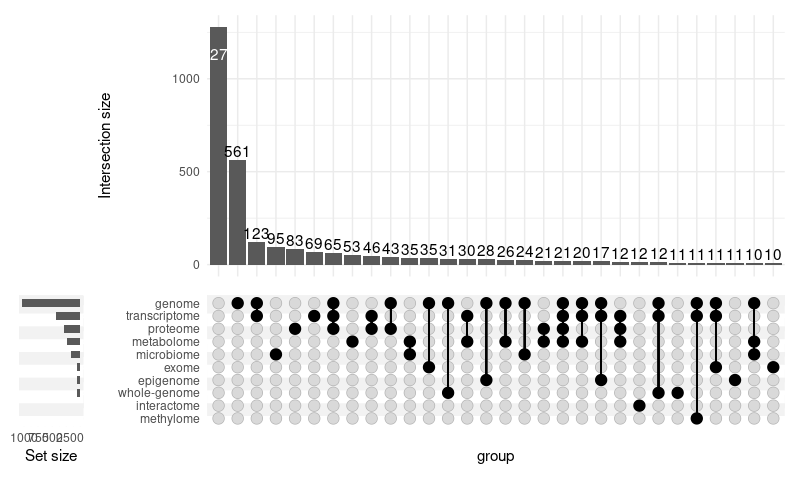

In [59]:
%%R -i ome_terms_mentioned -w 800 -r 100

upset(ome_terms_mentioned, colnames(ome_terms_mentioned), min_size=10, width_ratio=0.1)

[1] "Dropping 21 empty groups"


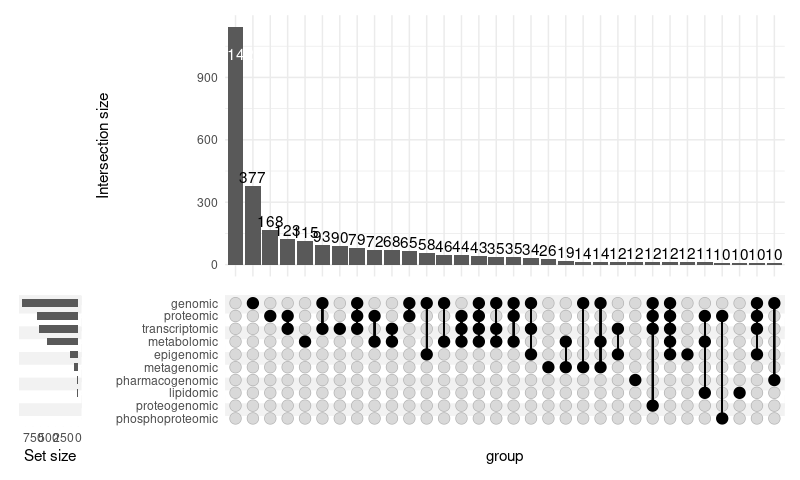

In [60]:
%%R -i omic_terms_mentioned -w 800 -r 100

upset(omic_terms_mentioned, colnames(omic_terms_mentioned), min_size=10, width_ratio=0.1)

## Merge -ome and -omic terms

In [61]:
from warnings import warn

terms_associated_with_omic = {
    omic + 's': [omic]
    for omic in omic_terms
}

for ome in ome_terms:
    assert ome.endswith('ome')
    auto_generate_omic_term = ome[:-3] + 'omics'
    omic = auto_generate_omic_term
    if omic not in terms_associated_with_omic:
        if omic in omic_counts.index:
            warn(f'{omic} was removed at thresholding, but it is a frequent -ome!')
        else:
            print(f'Creating omic {omic}')
        terms_associated_with_omic[omic] = []

    terms_associated_with_omic[omic].append(ome)

terms_associated_with_omic

Creating omic whole-genomics
Creating omic exomics
Creating omic whole-exomics
Creating omic whole-transcriptomics
Creating omic exposomics
Creating omic translatomics
Creating omic viromics
Creating omic regulomics
Creating omic degradomics
Creating omic pan-genomics
Creating omic mycobiomics


{'genomics': ['genomic', 'genome'],
 'proteomics': ['proteomic', 'proteome'],
 'transcriptomics': ['transcriptomic', 'transcriptome'],
 'metabolomics': ['metabolomic', 'metabolome'],
 'epigenomics': ['epigenomic', 'epigenome'],
 'metagenomics': ['metagenomic', 'metagenome'],
 'lipidomics': ['lipidomic', 'lipidome'],
 'metatranscriptomics': ['metatranscriptomic', 'metatranscriptome'],
 'metaproteomics': ['metaproteomic', 'metaproteome'],
 'proteogenomics': ['proteogenomic'],
 'phosphoproteomics': ['phosphoproteomic', 'phosphoproteome'],
 'pharmacogenomics': ['pharmacogenomic'],
 'phenomics': ['phenomic', 'phenome'],
 'fluxomics': ['fluxomic', 'fluxome'],
 'meta-omics': ['meta-omic'],
 'glycomics': ['glycomic', 'glycome'],
 'metabonomics': ['metabonomic'],
 'radiomics': ['radiomic'],
 'methylomics': ['methylomic', 'methylome'],
 'microbiomics': ['microbiomic', 'microbiome'],
 'nutrigenomics': ['nutrigenomic'],
 'peptidomics': ['peptidomic', 'peptidome'],
 'secretomics': ['secretomic', 's

In [62]:
omics_by_entity = {
    'genes': {
        'genomics',
        'whole-genomics',
        'exomics',
        'whole-exomics',
        # associations
        'immunogenomics'
    },
    'transcripts': {
        'transcriptomics',
        'whole-transcriptomics',
        'mirnomics',
        'translatomics',  # the "final day" in life of a transcript
    },
    'proteins & peptides': {
        'proteomics',
        # proteogenomics is basicaly protein/peptite identification
        # using genomic data, see https://doi.org/10.1038/nmeth.3144
        'proteogenomics',
        'peptidomics',
        # secretomics - study of all secreted proteins
        'secretomics',
        # degradomics is the study of proteases, substrates & inhibitors
        # using genomic & proteomic data, see https://doi.org/10.1038/nrm858
        'degradomics',
    },
    # both microbes, viruses AND animals!
    'clades (meta-* & pan-*)': {
        # for the sake of methods comparisons, the meta-*omic data are so different
        # (being a mix of thousands of organisms) that it warrants considering
        # those meta-Xomic as separate from Xomics (e.g. metagenomics as separate
        # from genomics)
        'metagenomics',
        'metatranscriptomics',
        'metaproteomics',
        'meta-omics',
        'microbiomics',  # used as a synonym for metagenomics, but there are other uses too
        'mycobiomics',
        'viromics',   # = viral metagenomics (but sometimes also viral genomics...)
        'pan-genomics',  # genes of all strains in a species/clade;
                         # used for microbiome but also for plants and human https://doi.org/10.1038/s41576-020-0210-7
    },
    'epigenetic modifications': {
        'epigenomics',
        'methylomics'
    },
    'protein modifications': {
        'glycoproteomics',
        'phosphoproteomics',
    },
    # drugs, toxins, diet & interactions
    'exogenous factors': {
        # metabolomic
        'exposomics',
        'pharmacometabolomics',
        # genomic
        'pharmacogenomics',
        'nutrigenomics',
        'toxicogenomics'
    },
    'endogenous metabonomics': {
        'metabonomics',
        'lipidomics',
        'metabolomics',
        'glycomics',
        'fluxomics'
    },
    'clinical data': {
        'radiogenomics',
        'radiomics',
        'phenomics'
    }
}

omics_by_entity_group = {
    'proteins, peptides & modifications': {
        *omics_by_entity['proteins & peptides'],
        *omics_by_entity['protein modifications']
    },
    'metabonomics': {
        *omics_by_entity['endogenous metabonomics'],
        'exposomics',
        'pharmacometabolomics',
    },
    'genes, epigenetics & genetic associations': {
        *omics_by_entity['genes'],
        *omics_by_entity['epigenetic modifications'],
        'pharmacogenomics',
        'nutrigenomics',
        'radiogenomics',
        'toxicogenomics'
    },
    'clades (meta-* & pan-*)': omics_by_entity['clades (meta-* & pan-*)'],
    'transcripts': omics_by_entity['transcripts'],
    'clinical data': omics_by_entity['clinical data']
}

interactomics is a proper "omics", but it is difficult to assign to a single entity - by definition

In [63]:
check_usage_in_input('interactomics')

uid
19910409    termines abundance of small cellular metabolites; interactomics, which resolves the whole set of...
22510581    sent study we performed an integrated proteomics, interactomics and metabolomics analysis of Lon...
23137709    ed investigations (metabolomics, transcriptomics, interactomics, phosphoproteomics, mathematical...
23248778    tis through genomics, trascriptomics, proteomics, interactomics, etc. These studies serve as fou...
25111155    mbining proteomics, transcriptomics, genomics and interactomics data. This approach identified a...
Name: title_abstract_text_subjects, dtype: object

phylogenomics is not an omic on its own, but if used in context of metagenomics it can refer to actual omics data

In [64]:
check_usage_in_input('phylogenomics')

uid
23122336    ematic analysis of the Hsf family in rice using a phylogenomics-based approach that integrates m...
27480683    stems. Recent advances in genomics, metabolomics, phylogenomics, and synthetic biology now enabl...
27540739    segmentally duplicated (Itoh et al. \nTo date, six phylogenomics databases have been developed f...
27633273    otation browser, genes and proteins, epitope map, phylogenomics, molecular diagnostic primers, t...
Name: title_abstract_text_subjects, dtype: object

regulomics is both a name of a tool, group (@MIM UW), and omics:

In [65]:
check_usage_in_input('regulomics')

uid
30985253     to integrate transcriptomics, interactomics, and regulomics data in  using a network-based mult...
31494994                                        s is available at http://bioinfo.sibs.ac.cn/plant-regulomics.  
Name: title_abstract_text_subjects, dtype: object

In [66]:
from functools import reduce
omics_mapped_to_entities = reduce(set.union, omics_by_entity.values())
set(terms_associated_with_omic) - omics_mapped_to_entities

{'interactomics', 'phylogenomics', 'regulomics'}

In [67]:
assert omics_mapped_to_entities - set(terms_associated_with_omic) == set()

In [68]:
omics_mapped_to_entities_groups = reduce(set.union, omics_by_entity_group.values())
set(terms_associated_with_omic) - omics_mapped_to_entities_groups

{'interactomics', 'phylogenomics', 'regulomics'}

In [69]:
from omics import add_entities_to_features


add_entities_to_omic_features = partial(
    add_entities_to_features,
    features=omics_features,
    omics_terms=terms_associated_with_omic
)

In [70]:
omics = {k: [k] for k in terms_associated_with_omic}
add_entities_to_omic_features(omics, entity_type='ome_or_omic')

,ome_or_omic,terms
0,genomics,"[genome, genomic]"
1,proteomics,"[proteome, proteomic]"
2,transcriptomics,"[transcriptome, transcriptomic]"
3,metabolomics,"[metabolome, metabolomic]"
4,epigenomics,"[epigenome, epigenomic]"
5,metagenomics,"[metagenome, metagenomic]"
6,lipidomics,"[lipidome, lipidomic]"
7,metatranscriptomics,"[metatranscriptome, metatranscriptomic]"
8,metaproteomics,"[metaproteome, metaproteomic]"
9,proteogenomics,[proteogenomic]


In [71]:
add_entities_to_omic_features(omics_by_entity, entity_type='entity')

,entity,terms
0,genes,"[exome, genome, genomic, immunogenomic, whole-exome, whole-genome]"
1,transcripts,"[mirnome, mirnomic, transcriptome, transcriptomic, translatome, whole-transcriptome]"
2,proteins & peptides,"[degradome, peptidome, peptidomic, proteogenomic, proteome, proteomic, secretome, secretomic]"
3,clades (meta-* & pan-*),"[meta-omic, metagenome, metagenomic, metaproteome, metaproteomic, metatranscriptome, metatranscr..."
4,epigenetic modifications,"[epigenome, epigenomic, methylome, methylomic]"
5,protein modifications,"[glycoproteomic, phosphoproteome, phosphoproteomic]"
6,exogenous factors,"[exposome, nutrigenomic, pharmacogenomic, pharmacometabolomic, toxicogenomic]"
7,endogenous metabonomics,"[fluxome, fluxomic, glycome, glycomic, lipidome, lipidomic, metabolome, metabolomic, metabonomic]"
8,clinical data,"[phenome, phenomic, radiogenomic, radiomic]"


In [72]:
add_entities_to_omic_features(omics_by_entity_group, entity_type='entity_group')

,entity_group,terms
0,"proteins, peptides & modifications","[degradome, glycoproteomic, peptidome, peptidomic, phosphoproteome, phosphoproteomic, proteogeno..."
1,metabonomics,"[exposome, fluxome, fluxomic, glycome, glycomic, lipidome, lipidomic, metabolome, metabolomic, m..."
2,"genes, epigenetics & genetic associations","[epigenome, epigenomic, exome, genome, genomic, immunogenomic, methylome, methylomic, nutrigenom..."
3,clades (meta-* & pan-*),"[meta-omic, metagenome, metagenomic, metaproteome, metaproteomic, metatranscriptome, metatranscr..."
4,transcripts,"[mirnome, mirnomic, transcriptome, transcriptomic, translatome, whole-transcriptome]"
5,clinical data,"[phenome, phenomic, radiogenomic, radiomic]"


### Visualize the entities & entities groups

In [73]:
omic_entities = omics_features['entity_' + Series(list(omics_by_entity.keys()))].rename(columns=prefix_remover('entity_'))
omic_entities_groups = omics_features['entity_group_' + Series(list(omics_by_entity_group.keys()))].rename(columns=prefix_remover('entity_group_'))

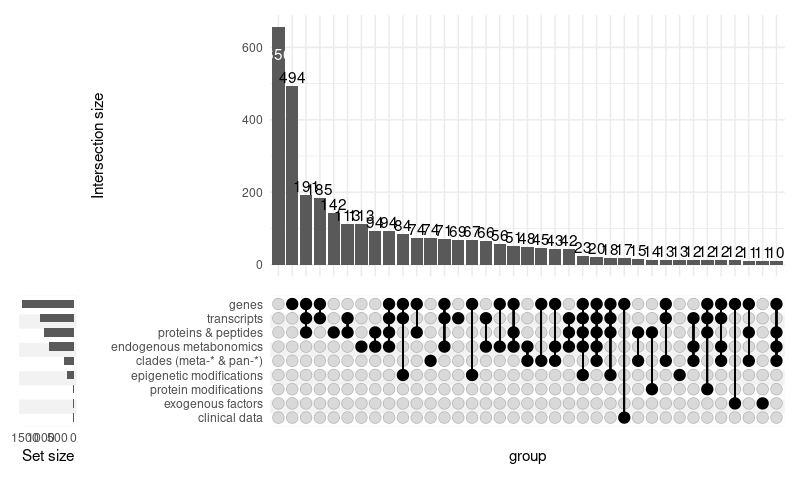

In [74]:
%%R -i omic_entities -w 800 -r 100

upset(omic_entities, colnames(omic_entities), min_size=10, width_ratio=0.1)

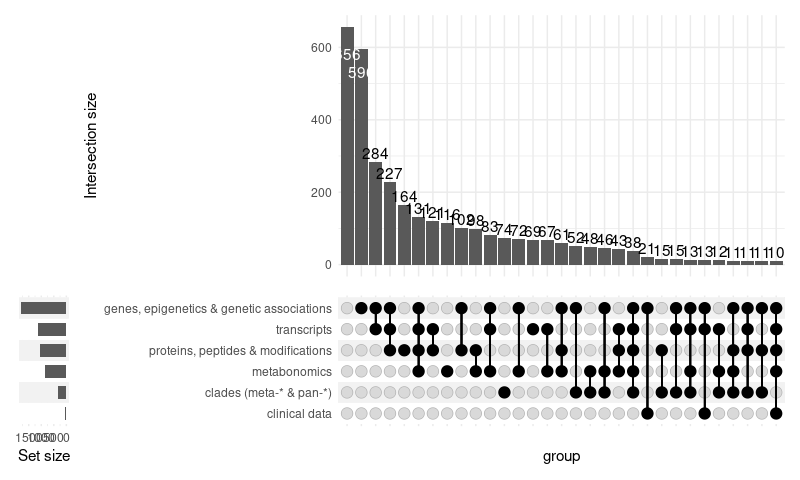

In [75]:
%%R -i omic_entities_groups -w 800 -r 100

upset(omic_entities_groups, colnames(omic_entities_groups), min_size=10, width_ratio=0.1)

### Number of omics mentioned in abstract vs the multi-omic term used

In [76]:
omes_or_omics_df = omics_features['ome_or_omic_' + Series(list(omics.keys()))].rename(columns=prefix_remover('ome_or_omic_'))

In [77]:
literature['omic_terms_in_abstract'] = omes_or_omics_df.sum(axis=1)

In [78]:
lt = literature[['term', 'omic_terms_in_abstract']]

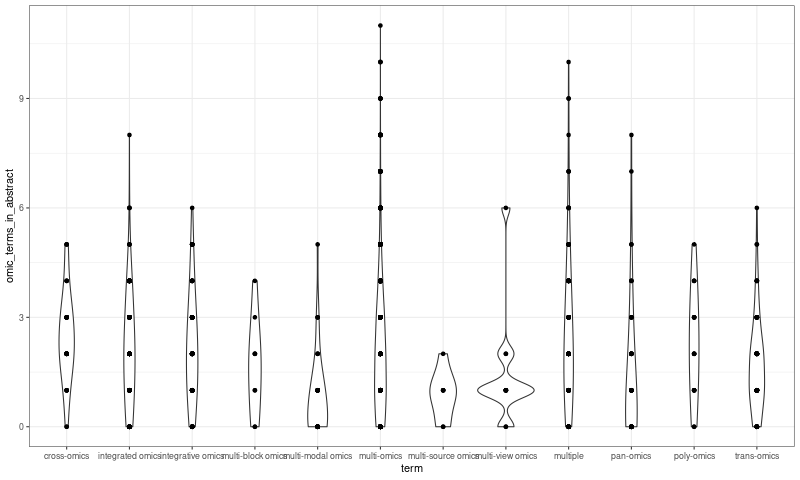

In [79]:
%%R -i lt -w 800
(
    ggplot(lt, aes(x=term, y=omic_terms_in_abstract))
    + geom_violin(adjust=2)
    + geom_point()
    + theme_bw()
)

# Current limitations

## Patchy coverage

Currently I only detected omic-describing terms in less than 70% of abstracts:

In [80]:
omic_entities.any(axis=1).mean()

0.8040035853002689

Potential solution: select a random sample of 50 articles, annotate manually, calculate sensitivity and specificity.

If any omic is consistently omitted, reconsider how search terms are created.

## Apostrophes

Are we missing out on \*'omic terms, such us meta'omic used in [here](https://doi.org/10.1053/j.gastro.2014.01.049)?

In [81]:
check_usage_in_input(
    r'\w+\'omic',
    words=False,
    highlight='\'omic'
)

uid
31142855    lable through the Inflammatory Bowel Disease Multi'omics Database ( http://ibdmdb.org ), provide...
32612960    ght and weight of our cohort. We performed a multi'omics [i.e., 16S rRNA amplicon and shotgun me...
Name: title_abstract_text_subjects, dtype: object

unlikely (but would be nice to get it in!)

## Fields of study

In [82]:
'genetics', 'epigenetics'

('genetics', 'epigenetics')

Some authors may prefer to say "we integrated genetic and proteomic data" rather than "genomic and proteomic"